In [ ]:
import numpy as np
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from dtaidistance import dtw
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import KMeans

In [57]:
df = pd.read_csv("output/data/discharge_tables/discharge_table_2001_2022.csv", index_col=0, parse_dates=True)

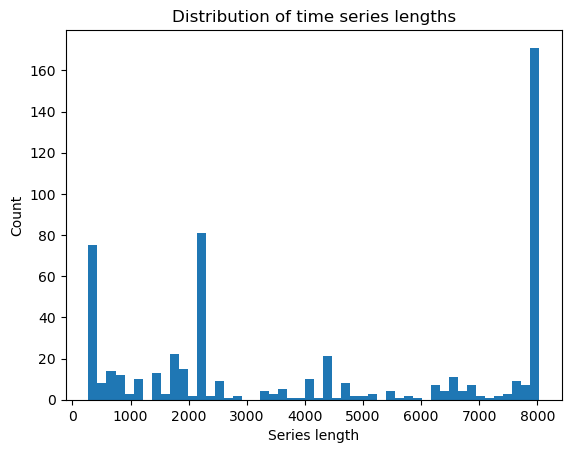

In [3]:
# Check the distribution of the time series length
series_lengths = [df[col].notna().sum() for col in df.columns]
plt.hist(series_lengths, bins=50)
plt.xlabel("Series length")
plt.ylabel("Count")
plt.title("Distribution of time series lengths")
plt.show()

In [ ]:
# According to the plot there are 3 obvious peaks, we cluster to find upper bounds that make 3 groups (short, medium, long)

lengths = np.array(series_lengths).reshape(-1, 1)

# convert to log 
log_lengths = np.log10(lengths)

# cluster the lengths
km = KMeans(n_clusters=3, random_state=42, n_init='auto')
km.fit(log_lengths)

# get cluster labels
labels = km.labels_

# collect clusters
clusters = []
for k in range(3):
    cluster_lenghts = 10 ** log_lengths[labels == k].flatten()
    clusters.append(cluster_lenghts)

# sort clusters by their median length
clusters_sorted = sorted(clusters, key=lambda c: np.median(c))

bound_1 = int(np.max(clusters_sorted[0])) # upper bound for short ts
bound_2 = int(np.max(clusters_sorted[1])) # upper bound for medium ts

print(f"Upper bounds: {bound_1}, {bound_2}")

Upper bounds: 935, 3726


In [ ]:
# Convert lengths into a pd Series with columns as index
lengths_series = pd.Series(lengths.flatten(), index=df.columns, name="length")

def assign_group(n):
    if n <= bound_1:
        return "short"
    elif n <= bound_2:
        return "medium"
    else:
        return "long"

# Apply the group label to the time series for later use
groups = lengths_series.apply(assign_group)

group_df = pd.DataFrame({
    "length": lengths_series,
    "group": groups
})
print(group_df.head())


          length   group
52000025    8035    long
15000046    6603    long
24000050    4018    long
46000019    7827    long
52000040    2191  medium


In [ ]:
TARGETS = {"short": 400, "medium": 2000, "long": 4000}
MAX_GAP = 14

def preprocess_series(ts, max_gap=MAX_GAP, target=TARGETS, sigma=3):
    # Interpolate small gaps
    ts = ts.interpolate(limit=max_gap, limit_direction="both")

    # Fill remaining NaNs with monthly mean
    monthly_mean = ts.groupby(ts.index.month).transform("mean")
    ts = ts.fillna(monthly_mean)

    # Extract longest continuous block
    mask = ts.notna()
    runs = (mask != mask.shift()).cumsum()
    sizes = mask.groupby(runs).sum()
    longest_run = sizes.idxmax()
    block = ts[runs == longest_run].dropna()
    if block.empty:
        return None, 0.0

    # Smooth
    x = gaussian_filter1d(block.values.astype(float), sigma=sigma, mode="reflect")

    # Resample to target length
    idx = np.linspace(0, len(x)-1, target)
    x = np.interp(idx, np.arange(len(x)), x)

    # Normalize
    x = (x - x.mean()) / x.std()

    coverage = len(block) / len(ts)
    return x, coverage

# Apply per group 
group_series = {"short": [], "medium": [], "long": []}
group_cov    = {"short": [], "medium": [], "long": []}

for col in df.columns:
    n = df[col].notna().sum()
    group = assign_group(n)
    target = TARGETS[group]
    x, cov = preprocess_series(df[col], target=target)
    if x is not None:
        group_series[group].append(x)
        group_cov[group].append(cov)

# Convert to arrays per group
arrays = {c: np.vstack(v) for c, v in group_series.items() if v}


In [ ]:
# Compute the dynamic time warping

distance_mats = {}

for group, data in arrays.items():
    print(f"Computing DTW for group: {group}, shape={data.shape}")
    D = dtw.distance_matrix_fast(data, parallel=True, compact=False)  
    distance_mats[group] = D

Computing DTW for group: short, shape=(110, 400)
Computing DTW for group: medium, shape=(175, 2000)
Computing DTW for group: long, shape=(285, 4000)


In [ ]:
# Label the series with their catchment ids
names_short = group_df[group_df["group"] == "short"].index
names_med   = group_df[group_df["group"] == "medium"].index
names_long  = group_df[group_df["group"] == "long"].index


# Build dataframes for each distance matrix with catchment ids
df_short = pd.DataFrame(distance_mats["short"], index=names_short, columns=names_short)
df_med   = pd.DataFrame(distance_mats["medium"],   index=names_med,   columns=names_med)
df_long  = pd.DataFrame( distance_mats["long"],  index=names_long,  columns=names_long)


In [ ]:
def plot_distance_matrix(D, title):
    # Randomly sample number of catchments
    num = 25
    sample_names = np.random.choice(D.index, size=num, replace=False)

    # Subset the dataframe
    distance_df_sample = D.loc[sample_names, sample_names]

    # Plot heatmap of the sampled subset
    plt.figure(figsize=(12, 10))
    sns.heatmap(distance_df_sample, annot=True, cmap="viridis", cbar=True)
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Plot each group
plot_distance_matrix(df_short, "DTW Distance Matrix - Short Group")
plot_distance_matrix(df_med, "DTW Distance Matrix - Medium Group")
plot_distance_matrix(df_long, "DTW Distance Matrix - Long Group")

### KMedoids

In [ ]:
def kmedoids_clustering(distance_df, k_range=range(2,20)):
    distance_matrix = distance_df.values # extract the distances
    series_names = distance_df.index # extract the catchment ids

    k_range = range(2,20)

    km_silhouette_scores = []
    km_davies_index = []
    km_elbow = []
    km_assignments = {}

    for k in k_range:
        model = KMedoids(n_clusters=k, metric="precomputed", random_state=42)
        labels = model.fit_predict(distance_matrix)
        
        # Store silhouette score ad Davies Bould Index
        sil = silhouette_score(distance_matrix, labels, metric="precomputed")
        km_silhouette_scores.append(sil)

        dbi = davies_bouldin_score(distance_matrix, labels)
        km_davies_index.append(dbi)
        
        # Compute WSS-like distortion (sum of distances to medoid)
        distortion = 0
        for cluster_id in range(k):
            members = np.where(labels == cluster_id)[0]
            medoid = model.medoid_indices_[cluster_id]
            distortion += distance_matrix[medoid, members].sum()
        
        km_elbow.append(distortion)

        # Save assignments for later use
        km_assignments[k] = pd.Series(labels, index=series_names, name=f"k={k}")

    return {
        "silhouette": km_silhouette_scores,
        "davies_bouldin": km_davies_index,
        "elbow": km_elbow,
        "assignments": km_assignments
    }

In [55]:
# Run KMedoids on datasets
results_short = kmedoids_clustering(df_short)
results_med   = kmedoids_clustering(df_med)
results_long  = kmedoids_clustering(df_long)

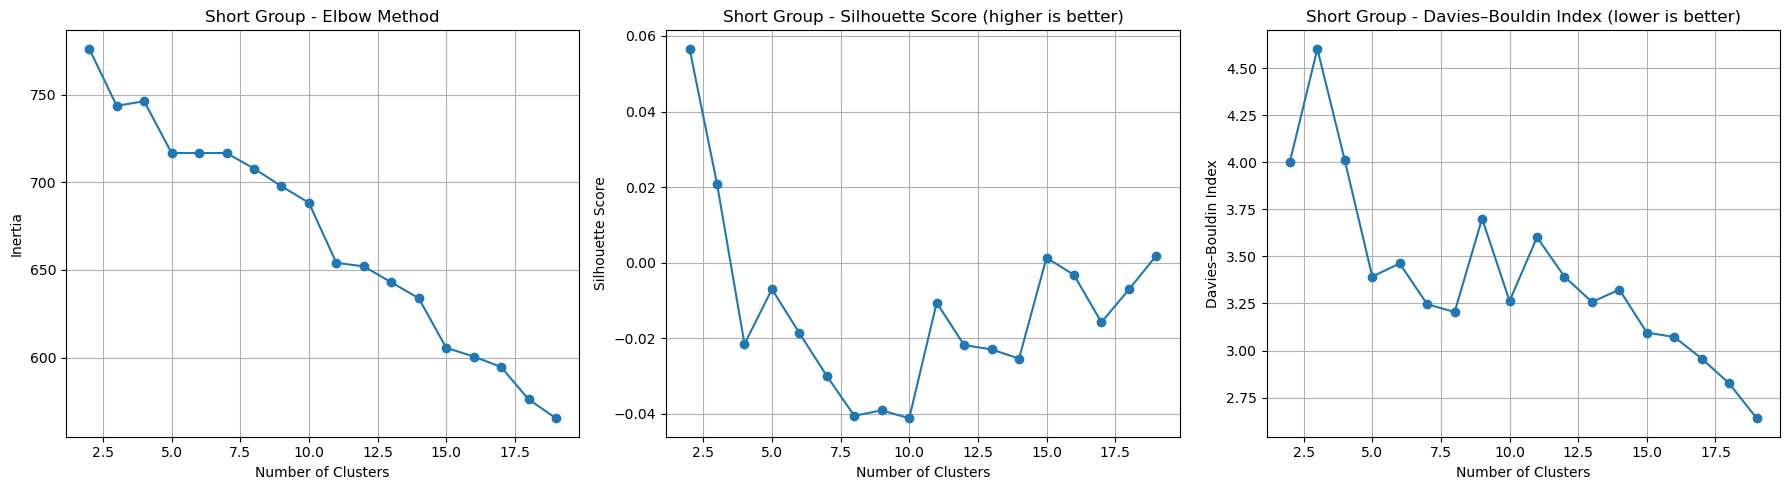

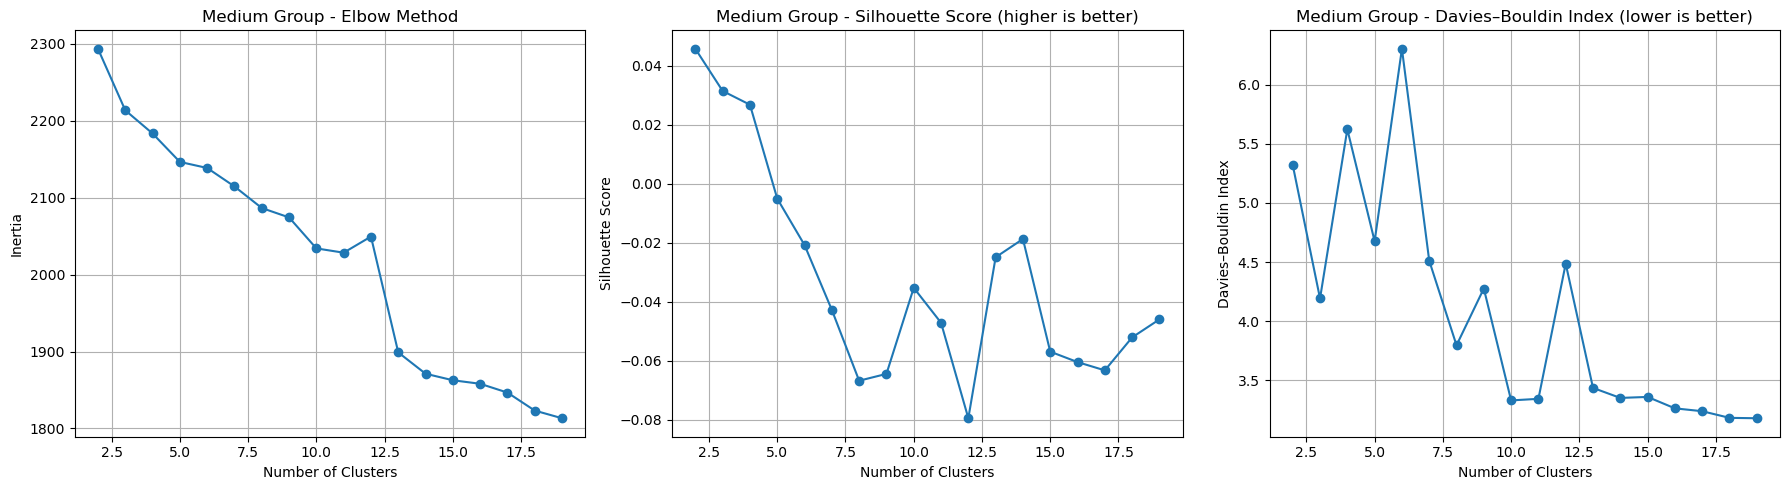

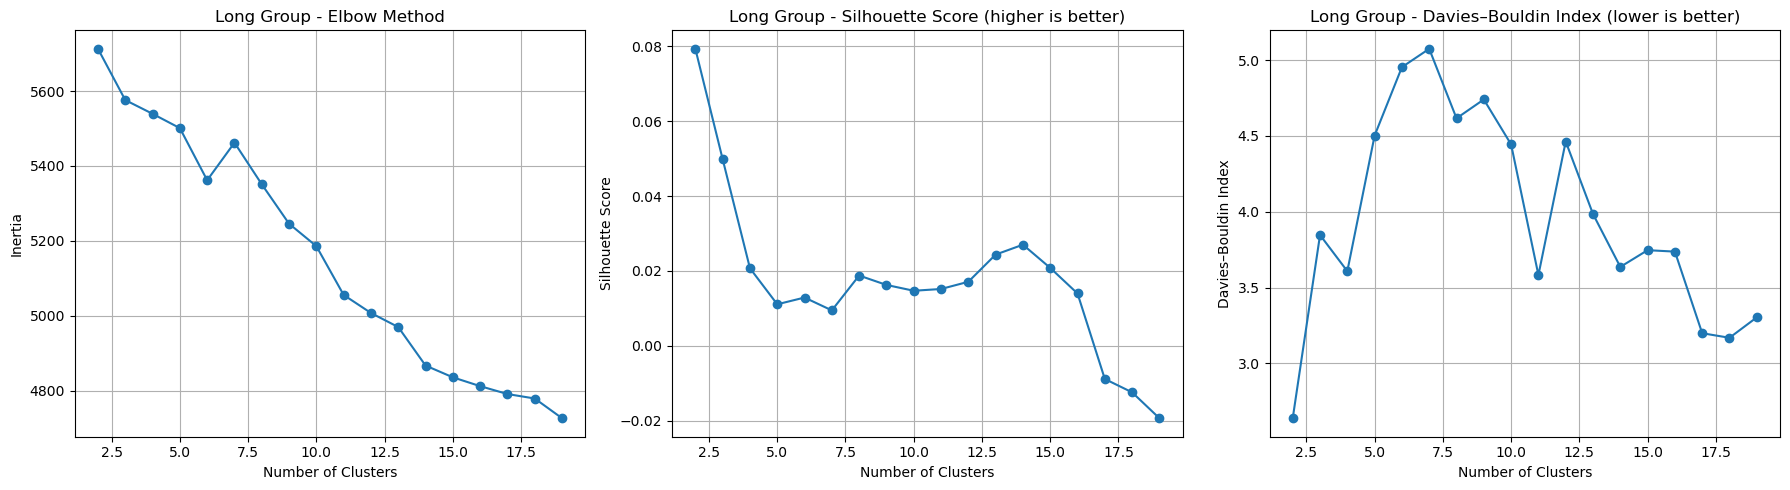

In [56]:
# Plot the scores

def plot_kmedoids_results(results, k_range, group_name):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Elbow
    axes[0].plot(k_range, results["elbow"], marker='o')
    axes[0].set_title(f'{group_name} - Elbow Method')
    axes[0].set_xlabel('Number of Clusters')
    axes[0].set_ylabel('Inertia')
    axes[0].grid(True)

    # Silhouette
    axes[1].plot(k_range, results["silhouette"], marker='o')
    axes[1].set_title(f'{group_name} - Silhouette Score (higher is better)')
    axes[1].set_xlabel('Number of Clusters')
    axes[1].set_ylabel('Silhouette Score')
    axes[1].grid(True)

    # Davies–Bouldin Index
    axes[2].plot(k_range, results["davies_bouldin"], marker='o')
    axes[2].set_title(f'{group_name} - Davies–Bouldin Index (lower is better)')
    axes[2].set_xlabel('Number of Clusters')
    axes[2].set_ylabel('Davies–Bouldin Index')
    axes[2].grid(True)

    plt.tight_layout()
    plt.show()


plot_kmedoids_results(results_short, range(2,20), "Short Group")
plot_kmedoids_results(results_med,   range(2,20), "Medium Group")
plot_kmedoids_results(results_long,  range(2,20), "Long Group")


In [ ]:
# save cluster assignments
def save_cluster_assignments(km_assignments, group_name, k_choice):
    # Combine assignments into one dataFrame
    assignments_df = pd.concat(km_assignments, axis=1)

    # Count labels per cluster size
    label_counts = {
        col: assignments_df[col].value_counts().sort_index()
        for col in assignments_df.columns
    }
    label_counts_df = pd.DataFrame(label_counts).fillna(0).astype(int)

    # Select chosen k column
    output_df = assignments_df[[k_choice]].reset_index()
    output_df.rename(columns={'index': 'catchment_id',
                              k_choice: 'cluster'}, inplace=True)

    # Save to CSV
    filename = f"{group_name}_{k_choice}_labels.csv"
    output_df.to_csv(filename, index=False)

    return assignments_df, label_counts_df, output_df


assignments_short, counts_short, output_short = save_cluster_assignments(results_short["assignments"], "short", 11)
assignments_med,   counts_med,   output_med   = save_cluster_assignments(results_med["assignments"],   "medium", 13)
assignments_long,  counts_long,  output_long  = save_cluster_assignments(results_long["assignments"],  "long",11)


## DBSCAN

In [31]:
# DBSCAN
def dbscan_clustering(distance_df, eps_values=range(2,20), min_samples_values=[2]):
    series_names = distance_df.index
    distance_matrix = distance_df.values

    dbscan_results = []
    dbscan_assignments = {}

    for eps in eps_values:
        for min_s in min_samples_values:
            model = DBSCAN(metric='precomputed', eps=eps, min_samples=min_s)
            labels = model.fit_predict(distance_matrix)

            # Count clusters and noise
            n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
            n_noise = list(labels).count(-1)

            # Scores (only if >1 cluster)
            if n_clusters > 1:
                sil = silhouette_score(distance_matrix, labels, metric="precomputed")
                dbi = davies_bouldin_score(distance_matrix, labels)
            else:
                sil, dbi = np.nan, np.nan

            dbscan_results.append({
                "eps": eps,
                "min_samples": min_s,
                "n_clusters": n_clusters,
                "noise_points": n_noise,
                "silhouette_score": sil,
                "davies_index": dbi
            })

            # Save assignments with names
            col_name = f"eps={eps}_min={min_s}"
            dbscan_assignments[col_name] = pd.Series(labels, index=series_names, name=col_name)

    results_df = pd.DataFrame(dbscan_results)
    assignments_df = pd.concat(dbscan_assignments, axis=1)

    return results_df, assignments_df


In [50]:
# Run DBSCAN on datasets
results_short, assignments_short = dbscan_clustering(df_short)
results_med,   assignments_med   = dbscan_clustering(df_med)
results_long,  assignments_long  = dbscan_clustering(df_long)

In [ ]:
# Plot scores
def plot_dbscan_results(results_df, group_name):
    plt.figure(figsize=(12,6))
    plt.plot(results_df["eps"], results_df["silhouette_score"], label="Silhouette Score")
    plt.plot(results_df["eps"], results_df["davies_index"], label="Davies–Bouldin Index")
    plt.title(f"DBSCAN Evaluation - {group_name}")
    plt.xlabel("eps")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_dbscan_results(results_short, "Short Group")
plot_dbscan_results(results_med,   "Medium Group")
plot_dbscan_results(results_long,  "Long Group")

In [53]:
# Check the results of one dataset to see the optimal eps
df_valid = results_long.dropna(subset=['silhouette_score', 'davies_index'])

# Best by Silhouette
best_sil_row = df_valid.loc[df_valid['silhouette_score'].idxmax()]
best_sil_eps = int(best_sil_row['eps'])
print(f"Best eps by silhouette score: {best_sil_eps} (score={best_sil_row['silhouette_score']:.3f})")

# Best by Davies Bouldin
best_dbi_row = df_valid.loc[df_valid['davies_index'].idxmin()]
best_dbi_eps = int(best_dbi_row['eps'])
print(f"Best eps by Davies–Bouldin Index: {best_dbi_eps} (DBI={best_dbi_row['davies_index']:.3f})")


Best eps by silhouette score: 19 (score=0.030)
Best eps by Davies–Bouldin Index: 2 (DBI=1.025)


In [ ]:
# select eps from above
chosen_eps = best_sil_eps  # or best_dbi_eps
chosen_col = f"eps={chosen_eps}_min=2"


output_df = assignments_long[[chosen_col]].reset_index()
output_df.rename(columns={'index': 'catchment_id', chosen_col: 'cluster'}, inplace=True)

group_name = "long"  
filename = f"{group_name}_dbscan_eps{chosen_eps}.csv"
output_df.to_csv(filename, index=False)
print(f"Saved cluster assignments to {filename}")
